In [1]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials

import pickle

In [2]:
postcodecsv = pd.read_csv("au_postcodes.csv")
# References:
# https://blog.greglow.com/2019/11/05/power-bi-creating-a-topojson-file-of-australian-postcodes-for-use-with-shape-map/
# https://mapshaper.org/
# https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument

from statistics import mean, median

import pandas as pd
from scipy import stats

ndf = pd.read_json("POA_2016_AUST.json")
ndf1 = ndf["features"].apply(pd.Series)
ndf2 = ndf1["geometry"].apply(pd.Series)
ndf3 = ndf1["properties"].apply(pd.Series)
border = ndf2["coordinates"]

depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1


def flatten(d, l=1):
    for i in d:
        yield from ([i] if l == 1 else flatten(i, l - 1))


def centerlocation(index):
    tmplst = list(flatten(border[index], l=depth(border[index])))
    longi = median([i for i in tmplst if i > 0])
    lati = median([i for i in tmplst if i < 0])
    return [longi, lati]


postcodedf = []
i = 0
for i in range(len(ndf)):
    if depth(border[i]) > 0:
        tpd = {
            "postcode": [ndf3["POA_CODE16"].iloc[i]],
            "longitude": [centerlocation(i)[0]],
            "latitude": [centerlocation(i)[1]],
        }
        tpdf = pd.DataFrame(tpd)
        postcodedf.append(tpdf)
    else:
        print(i)
        continue
    i = i + 1
postcodedf = pd.concat(postcodedf, ignore_index=True)

2668
2669


In [3]:
data = pd.read_csv(
    "./markettrends0.csv",
    dtype={
        "state": "str",
        "sa3_name16": "str",
        "sa4_name16": "str",
        "postcode": "str",
        "state": "str",
        "property_type": "str",
    },
)
ndata = data.fillna(
    {"Volume of new rental listings (1 month)": 0, "Volume of sales (1 month)": 0}
).dropna(subset=["postcode"])
ndatahouses = ndata[:][ndata.property_type == "Houses"]
ndataunits = ndata[:][ndata.property_type == "Units"]

In [4]:
# ndatahouses

In [5]:
# ndatahouses['postcode'].loc[ndatahouses['sa3_name16'] == 'Darwin City' ].unique()


In [6]:
# So far, Houses only
UniqueNames_sa3 = ndatahouses.sa3_name16.unique()[:-1]


In [7]:
# DataFrameDict_sa3 
# DataFrameDict_sa3 = {elem: pd.DataFrame for elem in UniqueNames_sa3}
# for key in DataFrameDict_sa3.keys():
#     DataFrameDict_sa3[key] = ndata[:][ndata.sa3_name16 == key]

In [8]:
year = list(range(2001, 2021))

In [9]:
DataFrameDict_HILDAp = {elem: pd.DataFrame for elem in year}
for key in DataFrameDict_HILDAp.keys():
    order = key - 2001
    ini = string.ascii_lowercase[order]
    df, meta = pyreadstat.read_dta(f"Rperson_{ini}200u.dta")
    df.columns = df.columns.str[1:]
    DataFrameDict_HILDAp[key] = df

In [10]:
# Pickle1 
# with open('DataFrameDict_HILDAp.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_HILDAp, f)

In [11]:
DataFrameDict_HILDA_cw = {elem: pd.DataFrame for elem in year}
for key in DataFrameDict_HILDA_cw.keys():
    order = key - 2001
    ini = string.ascii_lowercase[order]
    df, meta = pyreadstat.read_dta(f"Combined_{ini}200u.dta")
    df.columns = df.columns.str[1:]
    DataFrameDict_HILDA_cw[key] = df

In [12]:
# with open('DataFrameDict_HILDA_cw.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_HILDA_cw, f)

In [13]:
DataFrameDict_HILDA = {elem: pd.DataFrame for elem in year}
for key in DataFrameDict_HILDA.keys():
    order = key - 2001
    ini = string.ascii_lowercase[order]
    df, meta = pyreadstat.read_dta(f"Household_{ini}200u.dta")
    df.columns = df.columns.str[1:]
    DataFrameDict_HILDA[key] = df

In [14]:
# with open('DataFrameDict_HILDA.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_HILDA, f)

In [15]:

list_postcodes = DataFrameDict_HILDA[2001]["hhpcode"]
for key in DataFrameDict_HILDA.keys():
    list_ny = DataFrameDict_HILDA[key]["hhpcode"]
    list_postcodes = list(set(list_postcodes).intersection(list_ny))
count_dict = dict()
for key in DataFrameDict_HILDA.keys():
    for item in DataFrameDict_HILDA[key]["hhpcode"].unique():
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1
df_allpostcode = pd.DataFrame(count_dict.items())

In [16]:
HILDAallpc = df_allpostcode[0].values

In [17]:
df_retainedpc = df_allpostcode.drop(df_allpostcode[df_allpostcode[1] < 20].index)

In [18]:
UniquePostcode = df_retainedpc[0]
DataFrameDict_postcode = {elem: pd.DataFrame for elem in UniquePostcode}
for key in DataFrameDict_postcode.keys():
    DataFrameDict_postcode[key] = ndatahouses[:][ndatahouses.postcode == key]

In [19]:
def unique_non_null(s):
    return s.dropna().unique()


# placepc  = postcodedf['Postcode']

growthrate = []

for key in DataFrameDict_postcode.keys():
    if sum(postcodedf["postcode"] == key) > 0:
        # ind = placepc.loc[placepc == pc].index[0]
        ind = postcodedf.loc[postcodedf["postcode"] == key].index[0]
        df = DataFrameDict_postcode[key]
        if len(df["Hedonic Home Value Index"]) > 360:
            tpd = {
                "UniqueNames_sa3": DataFrameDict_postcode[key]["sa3_name16"].unique(),
                "S/T": DataFrameDict_postcode[key]["state"].unique(),
                #'Postcode':[postcodedf.loc[ind,'Postcode']],
                # 'longitude':[postcodedf.loc[ind,'longitude']],
                #'latitude':[postcodedf.loc[ind,'latitude']],
                "Postcode": [postcodedf.loc[ind, "postcode"]],
                "longitude": [postcodedf.loc[ind, "longitude"]],
                "latitude": [postcodedf.loc[ind, "latitude"]],
                "Growth_Houses": [
                    df["Hedonic Home Value Index"].iloc[-1]
                    / df["Hedonic Home Value Index"].iloc[359]
                ],
                "FinalHPI_Houses": [df["Hedonic Home Value Index"].iloc[-1]],
                # 'Suburbs':", ". join( ((postcodecsv.loc[(postcodecsv['postcode'] ==int(postcodedf.loc[ind,'Postcode']))]['place_name']).tolist()))}
                "Suburbs": ", ".join(
                    (
                        (
                            postcodecsv.loc[(postcodecsv["postcode"] == int(key))][
                                "place_name"
                            ]
                        ).tolist()
                    )
                ),
            }
            tpdf = pd.DataFrame(tpd)
            growthrate.append(tpdf)
    else:
        print("area(value) %s: data incomplete" % (key))
        continue

growthrate = pd.concat(growthrate, ignore_index=True)
growthrate["Postcode"] = growthrate["Postcode"].astype(str)

In [20]:
ndfsa3 = pd.read_json("SA3_2016_AUST.json")
ndf1sa3 = ndfsa3["features"].apply(pd.Series)
ndf2sa3 = ndf1sa3["geometry"].apply(pd.Series)
ndf3sa3 = ndf1sa3["properties"].apply(pd.Series)
borderdsa3 = ndf2sa3["coordinates"]
placename = ndf3sa3["SA3_NAME16"]

In [21]:



growthsa3 = []

i = -1

for key in DataFrameDict_sa3.keys():
    i = i + 1
    ind = placename[placename == difflib.get_close_matches(key, placename)[0]].index[0]
    df = DataFrameDict_sa3[key]
    tpd = {
        "UniqueNames_sa3": [DataFrameDict_sa3[key]["sa3_name16"].unique()[0]],
        "sa3code": [ndf3sa3.loc[ind, "SA3_CODE16"]],
        "FinalHPI_Houses": [
            DataFrameDict_sa3[key][df.value_at_date == "2021-05-31"][
                "Hedonic Home Value Index"
            ].mean()
        ],
    }
    tpdf = pd.DataFrame(tpd)
    growthsa3.append(tpdf)
growthsa3 = pd.concat(growthsa3, ignore_index=True)

NameError: name 'DataFrameDict_sa3' is not defined

# New Map Updated

- Suburbs without enough samples in HILDA are removed. 
- Standard of this version: missing rate is greater than 0% or suburbs not included in HILDA data 
- Link: https://lyulingfeng95.github.io/Project1_LF/


In [ ]:
folium_map4 = folium.Map(location=[-30, 138], zoom_start=4.4, titles="cartodbpositron")


f = open("POA_2016_AUST.json")
postcode_geo = json.load(f)
postcodedata2 = pd.DataFrame(
    {"postcode": df_retainedpc[0], "fill": [1] * len(df_retainedpc[0])}
)

folium.Choropleth(
    geo_data=postcode_geo,
    name="choropleth",
    data=postcodedata2,
    fill_color="BrBG",
    columns=["postcode", "fill"],
    key_on="feature.properties.POA_CODE16",
    fill_opacity=0.4,
    line_opacity=0.6,
).add_to(folium_map4)

mc1 = MarkerCluster(name="Marker Cluster")
df = growthrate
for index, row in df.iterrows():
    html = " Postcode: {}<br><br>Suburb(s): {}<br><br> Location (SA3): {} <br><br>State: {} <br><br> Fixed Based Growth Rate since 31/12/2009: {}  ".format(
        row["Postcode"],
        row["Suburbs"],
        row["UniqueNames_sa3"],
        row["S/T"],
        format(row["Growth_Houses"], ".4f"),
    )

    iframe = folium.IFrame(html)
    popup = folium.Popup(iframe, min_width=400, max_width=400)
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        color="blue",
        fill_opacity=math.pow(row["Growth_Houses"], 4) / 10,
        weight=0.8,
        popup=popup,
        fill=True,
    ).add_to(mc1)

mc1.add_to(folium_map4)

folium.LayerControl().add_to(folium_map4)

folium_map4

In [ ]:
# folium_map4.save("index.html")

In [22]:
# The average house price index growth rate.
aveHPI = []
lst = ["postcode", "date", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1990-12")
    ]
    df["logHPI"] = np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1990-12")
        ]
    )
    df["postcode"] = key
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI.append(df)

aveHPIdf = pd.concat(aveHPI)
aveHPIdf = aveHPIdf.reset_index(drop=True)
agg = aveHPIdf.groupby("Description")["logHPIdiff"].agg(["mean"]).reset_index()
agg.dropna()

,Description,mean
1,1991-01-31,0.000262
2,1991-02-28,0.007779
3,1991-03-31,0.007352
4,1991-04-30,0.011198
5,1991-05-31,0.008817
...,...,...
343,2019-07-31,-0.002407
344,2019-08-31,0.003430
345,2019-09-30,0.008324
346,2019-10-31,0.014621


In [23]:
xls1 = pd.read_excel("f01hist.xls", sheet_name="Data", header=2)
xls1 = xls1.drop(xls1.index[0:8], axis=0)
xls1["Description"] = pd.to_datetime(xls1["Description"])
xls1["Description"] = xls1["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls3 = pd.read_excel("f11hist-1969-2009.xls", sheet_name="Data", header=2)
xls3 = xls3.drop(xls3.index[0:8], axis=0)
xls3["Description"] = pd.to_datetime(xls3["Description"])
xls3["Description"] = xls3["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls4 = pd.read_excel("f11hist.xls", sheet_name="Data", header=2)
xls4 = xls4.drop(xls4.index[0:8], axis=0)
xls4["Description"] = pd.to_datetime(xls4["Description"])
xls4["Description"] = xls4["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls34 = pd.concat([xls3, xls4], axis=0)
xls5 = pd.read_excel("g01hist.xls", sheet_name="Data", header=2)
xls5 = xls5.drop(xls5.index[0:8], axis=0)
xls5["Description"] = pd.to_datetime(xls5["Description"])
xls5["Description"] = xls5["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls6 = pd.read_excel("h01hist.xls", sheet_name="Data", header=2)
xls6 = xls6.drop(xls6.index[0:8], axis=0)
xls6["Description"] = pd.to_datetime(xls6["Description"])
xls6["Description"] = xls6["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
xls7 = pd.read_excel("h03hist.xls", sheet_name="Data", header=2)
xls7 = xls7.drop(xls7.index[0:8], axis=0)
xls7["Description"] = pd.to_datetime(xls7["Description"])
xls7["Description"] = xls7["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))
# Download ASX data from Yahoo Finance

ASX200data = yf.download('^AXJO', start='1999-01-01', end='2021-06-01', interval = "1mo", progress=False)
ASX200data = ASX200data.reset_index()
ASX200data["Description"] = pd.to_datetime(ASX200data["Date"])
ASX200data["Description"] = ASX200data["Description"].dt.date.apply(lambda x: x.strftime("%Y-%m"))

In [24]:
# macvar = pd.DataFrame().assign(
#     Description=xls7.loc[
#         ("2021-06" > xls7["Description"]) & (xls7["Description"] > "1998-12")
#     ]["Description"]
# )
# macvar.reset_index(drop=True, inplace=True)

# macvar = pd.merge(
#     macvar,
#     xls1[["Description", "Cash Rate Target; monthly average"]],
#     on="Description",
#     how="left",
# )
# macvar = pd.merge(
#     macvar,
#     xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
#     on="Description",
#     how="left",
# )
# macvar = pd.merge(
#     macvar,
#     xls5[["Description", "Consumer price index; All groups"]],
#     on="Description",
#     how="left",
# )
# macvar = pd.merge(
#     macvar,
#     xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
#     on="Description",
#     how="left",
# )
# macvar = pd.merge(
#     macvar,
#     xls7[["Description", "Retail sales; All industries; Current price"]],
#     on="Description",
#     how="left",
# )
# macvar = pd.merge(
#     macvar,
#     xls7[["Description", "Private dwelling approvals"]],
#     on="Description",
#     how="left",
# )

# macvar = macvar.set_axis(
#     ["date", "ir", "exr", "cpi", "gdp", "rs", "pda"], axis=1, inplace=False
# )
# macvar["ir"] = macvar["ir"].astype(float, errors="raise")
# macvar["exr"] = macvar["exr"].astype(float, errors="raise")
# macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
# macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
# macvar["rs"] = macvar["rs"].astype(float, errors="raise")
# macvar["pda"] = macvar["pda"].astype(float, errors="raise")
# macvar = macvar.interpolate()
# macvarst = macvar


# lag = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# threshold = 0.01
# for i in lag:
#     if adfuller(macvar["ir"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"ir{i}"] = macvar["ir"].pct_change(i)
#     if adfuller(macvar["ir"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"ir{i}_2"] = macvar["ir"].pct_change(i).diff()

#     if adfuller(macvar["exr"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"exr{i}"] = macvar["exr"].pct_change(i)
#     if adfuller(macvar["exr"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"exr{i}_2"] = macvar["exr"].pct_change(i).diff()

#     if adfuller(macvar["cpi"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"cpi{i}"] = macvar["cpi"].pct_change(i)
#     if adfuller(macvar["cpi"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"cpi{i}_2"] = macvar["cpi"].pct_change(i).diff()

#     if adfuller(macvar["gdp"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"gdp{i}"] = macvar["gdp"].pct_change(i)
#     if adfuller(macvar["gdp"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"gdp{i}_2"] = macvar["gdp"].pct_change(i).diff()

#     if adfuller(macvar["rs"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"rs{i}"] = macvar["rs"].pct_change(i)
#     if adfuller(macvar["rs"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"rs{i}_2"] = macvar["rs"].pct_change(i).diff()

#     if adfuller(macvar["pda"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"pda{i}"] = macvar["pda"].pct_change(i)
#     if adfuller(macvar["pda"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"pda{i}_2"] = macvar["pda"].pct_change(i).diff()

In [25]:
macvar = pd.DataFrame().assign(
    Description=xls7.loc[
        ("2021-06" > xls7["Description"]) & (xls7["Description"] > "1998-12")
    ]["Description"]
)
macvar.reset_index(drop=True, inplace=True)

macvar = pd.merge(
    macvar,
    xls1[["Description", "Cash Rate Target; monthly average"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls34[["Description", "AUD/USD Exchange Rate; see notes for further detail."]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls5[["Description", "Consumer price index; All groups"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls6[["Description", "Gross domestic product (GDP); Chain volume"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Retail sales; All industries; Current price"]],
    on="Description",
    how="left",
)
macvar = pd.merge(
    macvar,
    xls7[["Description", "Private dwelling approvals"]],
    on="Description",
    how="left",
)

macvar = pd.merge(
    macvar,
    ASX200data[["Description", "Adj Close"]],
    on="Description",
    how="left",
)



In [26]:
macvar = macvar.set_axis(
    ["date", "ir", "exr", "cpi", "gdp", "rs", "pda", "asx"], axis=1, inplace=False
)


macvar["ir"] = macvar["ir"].astype(float, errors="raise")
macvar["exr"] = macvar["exr"].astype(float, errors="raise")
macvar["cpi"] = macvar["cpi"].astype(float, errors="raise")
macvar["gdp"] = macvar["gdp"].astype(float, errors="raise")
macvar["rs"] = macvar["rs"].astype(float, errors="raise")
macvar["pda"] = macvar["pda"].astype(float, errors="raise")
macvar["asx"] = macvar["asx"].astype(float, errors="raise")
macvar = macvar.interpolate()

In [27]:
macvar

,date,ir,exr,cpi,gdp,rs,pda,asx
0,1999-01,4.75,0.6286,NaN,NaN,10768.4,11.942,2781.699951
1,1999-02,4.75,0.6225,NaN,NaN,10718.2,12.861,2768.399902
2,1999-03,4.75,0.6293,67.800000,280753.000000,10800.1,12.365,2867.000000
3,1999-04,4.75,0.6598,67.900000,281055.333333,10870.0,13.191,3027.800049
4,1999-05,4.75,0.6491,68.000000,281357.666667,10898.0,12.818,2831.899902
...,...,...,...,...,...,...,...,...
264,2021-01,0.10,0.7645,117.433333,504008.666667,30569.9,16.656,6607.399902
265,2021-02,0.10,0.7829,117.666667,507110.333333,30332.5,19.834,6673.299805
266,2021-03,0.10,0.7602,117.900000,510212.000000,30725.9,23.122,6790.700195
267,2021-04,0.10,0.7776,117.900000,510212.000000,30960.0,21.799,7025.799805


In [28]:
# A function used to obtain a stationay series from the original series
## Order: series itself; 1sr order; seasonal order; annual order; 2nd order. 
threshold = 0.01

def selectStationaySeries(variable_tar):
        if adfuller(variable_tar.dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar
            suffix =  "original"
        elif adfuller(variable_tar.pct_change(1).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).dropna(how="all")
            suffix = "1storderdiff"
        elif adfuller(variable_tar.pct_change(3).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(3).dropna(how="all")
            suffix = "seasonaldiff"
        elif adfuller(variable_tar.pct_change(12).dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(12).dropna(how="all")
            suffix = "annualdiff"     
        elif adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
            stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
            suffix = "2ndorderdiff"
        else:
            print("not found")
        return(pd.DataFrame(stationary_variable))


In [29]:
macvarst = macvar["date"] 
for vn in macvar.columns.values[1:]:
    macvarst = pd.concat([macvarst, selectStationaySeries(macvar[vn])], axis=1)
   


In [30]:
# macvarst = macvar
# lag = [1]

# for i in lag:
#     if adfuller(macvar["ir"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"ir{i}"] = macvar["ir"].pct_change(i)
#     if adfuller(macvar["ir"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"ir{i}_2"] = macvar["ir"].pct_change(i).diff()

#     if adfuller(macvar["exr"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"exr{i}"] = macvar["exr"].pct_change(i)
#     if adfuller(macvar["exr"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"exr{i}_2"] = macvar["exr"].pct_change(i).diff()

#     if adfuller(macvar["cpi"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"cpi{i}"] = macvar["cpi"].pct_change(i)
#     if adfuller(macvar["cpi"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"cpi{i}_2"] = macvar["cpi"].pct_change(i).diff()

#     if adfuller(macvar["gdp"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"gdp{i}"] = macvar["gdp"].pct_change(i)
#     if adfuller(macvar["gdp"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"gdp{i}_2"] = macvar["gdp"].pct_change(i).diff()

#     if adfuller(macvar["rs"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"rs{i}"] = macvar["rs"].pct_change(i)
#     if adfuller(macvar["rs"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"rs{i}_2"] = macvar["rs"].pct_change(i).diff()

#     if adfuller(macvar["pda"].pct_change(i).dropna(how="all"))[1] < threshold:
#         macvarst[f"pda{i}"] = macvar["pda"].pct_change(i)
#     if adfuller(macvar["pda"].pct_change(i).diff().dropna(how="all"))[1] < threshold:
#         macvarst[f"pda{i}_2"] = macvar["pda"].pct_change(i).diff()

In [31]:
month = [int(my_str.split("-")[1]) for my_str in macvarst["date"].values]
quater = [(m - 1) // 3 + 1 for m in month]
monthdummies = pd.get_dummies(month, prefix="month")
quaterdummies = pd.get_dummies(quater, prefix="quater")
dummies = pd.concat([monthdummies, quaterdummies], axis=1)
#macvarst  =  pd.concat([macvarst,dummies],axis =1)
#macvarst = pd.concat([macvarst, monthdummies], axis=1)

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# skip reading
# macvarsta = macvarst[
#     macvarst.columns.difference(["ir", "exr", "cpi", "gdp", "rs", "pda"])
# ]
# macvarsta = macvarst[macvarst.columns.difference(['ir','exr','cpi','gdp','rs','pda','loghpidiff'])]

macvarsta = macvarst  
matrixmac = macvarsta.corr().round(2)
macdata = macvarsta.loc[
    ("2019-12" > macvarsta["date"]) & (macvarsta["date"] > "2000-12")
]



In [33]:
macvarsta

,date,ir,exr,cpi,gdp,rs,pda,asx
0,1999-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-02,NaN,-0.009704,NaN,NaN,-0.004662,0.076955,-0.004781
2,1999-03,0.000000,0.010924,NaN,NaN,0.007641,-0.038566,0.035616
3,1999-04,0.000000,0.048467,NaN,NaN,0.006472,0.066801,0.056087
4,1999-05,0.000000,-0.016217,-0.000002,-0.000001,0.002576,-0.028277,-0.064700
...,...,...,...,...,...,...,...,...
264,2021-01,0.090909,-0.007401,-0.000861,-0.004300,0.001743,-0.128506,0.003082
265,2021-02,0.000000,0.024068,-0.000004,-0.000038,-0.007766,0.190802,0.009974
266,2021-03,0.000000,-0.028995,-0.000004,-0.000038,0.012970,0.165776,0.017593
267,2021-04,0.000000,0.022889,-0.001983,-0.006116,0.007619,-0.057218,0.034621


In [94]:
pca = PCA()
X_train = macdata.loc[:, macdata.columns != "date"]
poly= PolynomialFeatures(degree=2)
scaler = StandardScaler()

#X_train_poly = poly.fit_transform(X_train)
#X_train_std = scaler.fit_transform(X_train_poly)
X_train_std = scaler.fit_transform(X_train)



In [161]:
pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

pca_d = PCA(n_components=d)
pca_d.fit(X_train_std)
X_pca_d = pca_d.transform(X_train_std)
PCnames = []
for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
pcadf_date = pcadf
pcadf_date['date'] = agg.loc[("2019-12" > agg["Description"]) & (agg["Description"] > "2001-01")].reset_index()["Description"]
pcadf_date['date']  = pd.to_datetime(pcadf_date['date'])

6


In [113]:
pcadf_indexed

,PC1,PC2,PC3,PC4,PC5,PC6
date,,,,,,
2001-01-31,-1.479748,-1.619011,0.919218,2.145152,-1.509017,3.586024
2001-02-28,1.208162,-0.676357,-0.137276,-1.753030,-1.228802,1.314525
2001-03-31,2.103463,-0.503943,0.154876,0.525951,-1.402082,-0.490261
2001-04-30,-1.333464,0.534796,-1.877512,-0.884654,0.474470,-0.218984
2001-05-31,-0.981659,-0.261556,-0.653705,1.396659,-0.719057,-1.615308
...,...,...,...,...,...,...
2019-07-31,0.555179,0.393865,0.102087,-0.730271,0.729828,1.064550
2019-08-31,-0.172880,-1.790080,1.562770,1.639913,-0.943985,-2.891601
2019-09-30,-0.421501,0.026105,-0.306305,0.430355,-0.150649,-0.449909


0      2001-01-31
1      2001-02-28
2      2001-03-31
3      2001-04-30
4      2001-05-31
          ...    
222    2019-07-31
223    2019-08-31
224    2019-09-30
225    2019-10-31
226    2019-11-30
Name: Description, Length: 227, dtype: object

In [36]:
pca_avg = pd.concat(
    [
        pcadf,
        agg["mean"]
        .loc[("2019-12" > agg["Description"]) & (agg["Description"] > "2001-01")]
        .reset_index(drop=True),
    ],
    axis=1,
)
# skip reading
paneldata = []
lst = ["postcode", "date", "logHPI", "difflogHPI"]
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["date"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "2001-01")
    ]
    df["logHPI"] = np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
        ]
    )
    df["postcode"] = key
    df["difflogHPI"] = (
        (
            np.log2(
                DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
                    ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
                    & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
                ]
            )
        )
        .diff(1)
        .dropna()
    )
    data = pd.concat([df.reset_index(drop=True), pca_avg], axis=1)
    paneldata.append(data)
paneldf = pd.concat(paneldata, ignore_index=True)
paneldf["date"] = pd.to_datetime(paneldf["date"])
panelData = paneldf.set_index(["postcode", "date"])

In [37]:
DataFrameDict_PC = {elem: pd.DataFrame for elem in UniquePostcode}
lst = ["postcode", "date", "logHPI", "difflogHPI"]
# Calling DataFrame constructor on list
for key in DataFrameDict_PC.keys():
    df = pd.DataFrame([], columns=lst)
    df["date"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "2001-01")
    ]
    df["logHPI"] = np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
        ]
    )
    df["postcode"] = key
    df["difflogHPI"] = (
        (
            np.log2(
                DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
                    ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
                    & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
                ]
            )
        )
        .diff(1)
        .dropna()
    )
    data = pd.concat([df.reset_index(drop=True), pca_avg], axis=1)
    DataFrameDict_PC[key] = data

In [38]:
PCnames = []
for i in range(1, d + 1, 1):
    PCnames.append(f"PC{i}")
PCnames.append("mean")
df = pd.DataFrame(pca_avg, columns=PCnames)

nobs = 28  # post-covid data is used as the test data set
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size

start_point = df_train.shape[0]
print(df_train.shape)
print(df_test.shape)
model = VAR(df_train)
for i in [1,2,3, 4, 6, 7, 8]:
    result = model.fit(i)
    print("Lag Order =", i)
    print("AIC : ", result.aic)
    print("BIC : ", result.bic)
    print("FPE : ", result.fpe)
    print("HQIC: ", result.hqic, "\n")

(199, 7)
(28, 7)
Lag Order = 1
AIC :  -11.870714659276963
BIC :  -10.94069974150477
FPE :  6.994359296556418e-06
HQIC:  -11.494275532706629 

Lag Order = 2
AIC :  -11.868071527537415
BIC :  -10.118140606128843
FPE :  7.025218345014419e-06
HQIC:  -11.159686436631972 

Lag Order = 3
AIC :  -12.106694911669882
BIC :  -9.531033393703048
FPE :  5.559262301579472e-06
HQIC:  -11.063943685925537 

Lag Order = 4
AIC :  -11.987413172328536
BIC :  -8.580136708798072
FPE :  6.319587569721617e-06
HQIC:  -10.607847290309108 

Lag Order = 6
AIC :  -12.097660809101122
BIC :  -7.009216524850498
FPE :  5.877046506543263e-06
HQIC:  -10.037004394922427 

Lag Order = 7
AIC :  -11.896107215307225
BIC :  -5.957964610048247
FPE :  7.428654032409303e-06
HQIC:  -9.491115945341964 

Lag Order = 8
AIC :  -11.819775134024592
BIC :  -5.025758915225611
FPE :  8.388381353942635e-06
HQIC:  -9.067882508922658 



In [39]:
model_fitted = model.fit(2)
model_fitted.summary()
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)


for col, val in zip(df.columns, out):
    print(col, ":", round(val, 2))

lag_order = model_fitted.k_ar
forecast_input = df_train.values[-lag_order:]

df_forecast = []
for i in range(1, nobs + 1, 1):
    forecast_input = df.values[
        -lag_order + start_point + i - 1 : start_point + i - 1,
    ]
    df_forecast.append(
        model_fitted.forecast(y=forecast_input, steps=1)[
            0,
        ][-1]
    )


df_results = pd.DataFrame(df_forecast, index=df.index[-nobs:], columns=["forecast"])

forecast_input_lt = df_train.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input_lt, steps=nobs)

df_results_lt = pd.DataFrame(
    fc, index=df.index[-nobs:], columns=df.columns + "forecast"
)

PC1 : 2.01
PC2 : 2.03
PC3 : 2.08
PC4 : 1.94
PC5 : 2.02
PC6 : 2.09
mean : 2.07


In [40]:
df_forecast

[0.0017801926026845883,
 0.0006508285889967052,
 0.0027938273648393666,
 0.005106406183984062,
 0.004197307150583097,
 0.00030747053347719483,
 0.0006916584137127853,
 0.0032036695706571016,
 0.0011600694152344953,
 -0.0002480568744331748,
 -0.0010025496117184712,
 -0.0053826045237287444,
 -0.006545302002114334,
 -0.003087012091571699,
 -0.00592120965435722,
 -0.005859607699510303,
 -0.004633841794055463,
 -0.011962127108981426,
 -0.008417461913037945,
 -0.006534347105528596,
 -0.004231312099775866,
 -0.0037925647607342816,
 -0.004209517322000168,
 -0.001699752217786341,
 -0.0028923403322243363,
 0.0037544944010358544,
 0.01164829125423849,
 0.015596101953568111]

(array([-0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

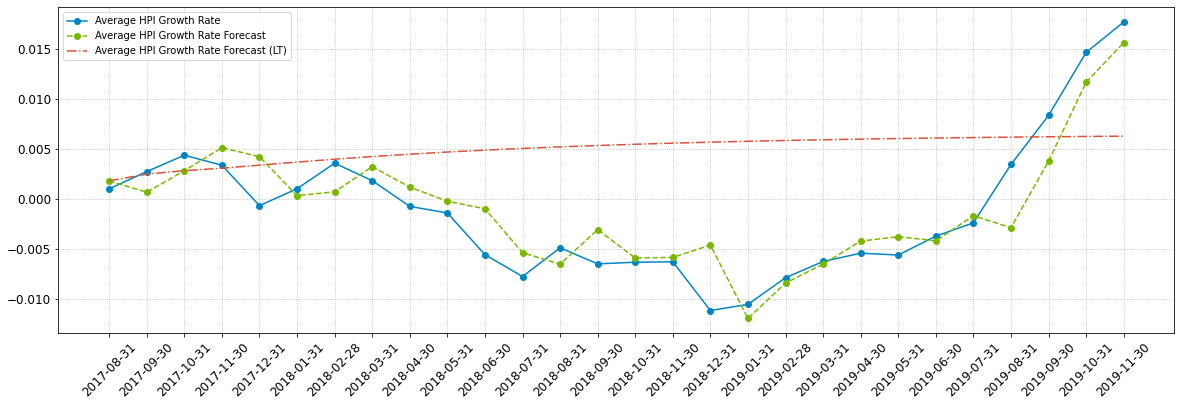

In [41]:
date_frame = pd.DataFrame(
    agg["Description"]
    .loc[("2019-12" > agg["Description"]) & (agg["Description"] > "2001-01")]
    .reset_index(drop=True)
)
x = date_frame[-nobs:]["Description"]
color1 = "#0085c3"
color2 = "#7ab800"
color3 = "#dc5034"
y = df_results["forecast"]
y2 = df_test["mean"][-nobs:]
y3 = savgol_filter(df_results_lt["meanforecast"], 5, 3)
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(x, y2, marker="o", color=color1, label="Average HPI Growth Rate")
ax.plot(
    x, y, marker="o", ls="--", color=color2, label="Average HPI Growth Rate Forecast"
)
ax.plot(x, y3, ls="-.", color=color3, label="Average HPI Growth Rate Forecast (LT)")

ax.grid(ls=":", color="gray", alpha=0.6)

ax.legend(loc="upper left", fontsize=10)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Mixed frequency data
- Introducing data at smaller scales with lower frequencies (e.g. annual) 
- Finding the principal components -> new risk factors at smaller scales
- New VAR models: average growth rate at smaller scales (annual)
- Combining average growth rates from VAR models
- Using risk factors(OLS) to explain excess house price growth rate
- Downsampling macroeconomic data (monthly) to annual date to build VAR model
- Deleting new risk factors when multicollinearity arises (?) 

In [42]:
import re


def nan_dum(df):
    df1_ohe = df
    nan_df = df1_ohe.loc[:, df1_ohe.columns.str.endswith("_nan")]
    pattern = "^([^_]*)_"
    regex = re.compile(pattern)
    for index in df1_ohe.index:
        for col_nan in nan_df.columns:
            if df1_ohe.loc[index, col_nan] == 1:
                col_id = regex.search(col_nan).group(1)
                targets = df1_ohe.columns[df1_ohe.columns.str.startswith(col_id + "_")]
                df1_ohe.loc[index, targets] = np.nan
    df1_ohe.drop(
        df1_ohe.columns[df1_ohe.columns.str.endswith("_nan")], axis=1, inplace=True
    )
    return df1_ohe

In [43]:
def person_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .loc[DataFrameDict_HILDAp[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)

In [44]:
def house_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1]
            .loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)

In [45]:
def house_cat(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1]
            .loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)

In [46]:
def person_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1].loc[
            DataFrameDict_HILDAp[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()

In [47]:
def house_num(postcode, lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1].loc[
            DataFrameDict_HILDA[key]["hhpcode"] == postcode
        ]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()

In [48]:
# lst1 variables in HOUSE files
# lst2 variables in PERSON files
def HILDAext_cat(postcode, lst1, lst2):
    dfHILDA1 = house_cat(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA

In [ ]:

def HILDAext_num(postcode, lst1, lst2):
    dfHILDA1 = house_num(postcode, lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num(postcode, lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA

In [50]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [51]:
lst_age = [f'hgdob{i}' for i in range(1, 21)]

def HILDAext_age(postcode):    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age].loc[DataFrameDict_HILDA[key]["hhpcode"] == postcode]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [52]:
#HILDAext_age(postcode)
#HILDAext_age1(postcode)
#which shows the household and enumerated dataset are different sources of data

# Variables from HILDA

[ancob] History: Country of birth

[edhigh1] History: Highest education level achieved

[anatsi]	History: Aboriginal or Torres Strait Islander origin


[chkb12]	Check B12 employment status

[wsce] DV: Current weekly gross wages & salary, all jobs, includes estimated from net ($) [weighted topcode]

[baynoa] Total amount held in these accounts combined [weighted topcode]

[xpgroci]	DV: Household weekly expenditure on all groceries [imputed]

[hsdebt]	DV: Total Home Debt ($) [weighted topcode]

[hgdob1] to [hgdob20] Date of birth

[hgsex]	Sex


```[hgyob]	Year of Birth```



In [53]:
varnames_catp = ["ancob", "edhigh1", "anatsi", "chkb12", "sex"]
# varnames_nump = ["wsce", "baynoa"]
varnames_nump = ["wsce"]
varnames_cath = []
#varnames_cath = ["xpgroci"]
varnames_numh = ["hsdebt"]

# Example
In this example, postcode is fixed to be "2018". We can see the results of two data extraction functions from HILDA data.  

In [54]:
HILDAext_num("2018", varnames_numh, varnames_nump)

,date,hsdebt,wsce
0,2001-12-31,-4.666667,164.307692
1,2002-12-31,0.000000,186.652174
2,2003-12-31,40332.133333,360.307692
3,2004-12-31,38265.466667,362.360000
4,2005-12-31,20538.461538,211.000000
5,2006-12-31,18928.571429,331.720000
6,2007-12-31,17142.857143,332.791667
7,2008-12-31,-1.400000,360.416667
8,2009-12-31,20932.733333,255.423077
9,2010-12-31,23152.461538,117.727273


In [55]:
HILDAext_cat("2018", varnames_cath, varnames_catp)

,date,ancob_-4,ancob_1101,ancob_1102,ancob_2100,ancob_2201,ancob_3308,ancob_5202,ancob_6101,ancob_7101,...,edhigh1_5,edhigh1_8,edhigh1_9,anatsi_-1,anatsi_1,anatsi_2,chkb12_-1,chkb12_1,chkb12_2,chkb12_3
0,2001-12-31,0.038462,0.538462,0.000000,0.038462,0.038462,0.153846,0.000,0.000000,0.000000,...,0.038462,0.230769,0.461538,0.461538,0.423077,0.115385,NaN,NaN,NaN,NaN
1,2002-12-31,0.043478,0.565217,0.000000,0.000000,0.043478,0.173913,0.000,0.043478,0.000000,...,0.043478,0.130435,0.478261,0.434783,0.434783,0.130435,0.695652,0.260870,0.000000,0.043478
2,2003-12-31,0.038462,0.615385,0.000000,0.038462,0.038462,0.153846,0.000,0.038462,0.000000,...,0.038462,0.192308,0.346154,0.384615,0.461538,0.153846,0.615385,0.346154,0.038462,0.000000
3,2004-12-31,0.040000,0.600000,0.000000,0.040000,0.040000,0.160000,0.000,0.040000,0.000000,...,0.040000,0.200000,0.320000,0.400000,0.440000,0.160000,0.600000,0.360000,0.000000,0.040000
4,2005-12-31,0.040000,0.600000,0.000000,0.000000,0.040000,0.160000,0.000,0.080000,0.000000,...,0.040000,0.200000,0.360000,0.400000,0.440000,0.160000,0.680000,0.280000,0.000000,0.040000
5,2006-12-31,0.040000,0.640000,0.040000,0.000000,0.040000,0.160000,0.000,0.000000,0.000000,...,0.040000,0.160000,0.400000,0.360000,0.480000,0.160000,0.680000,0.280000,0.000000,0.040000
6,2007-12-31,0.041667,0.666667,0.041667,0.000000,0.041667,0.125000,0.000,0.000000,0.000000,...,0.083333,0.125000,0.416667,0.333333,0.500000,0.166667,0.583333,0.375000,0.000000,0.041667
7,2008-12-31,0.041667,0.625000,0.041667,0.000000,0.041667,0.083333,0.000,0.000000,0.083333,...,0.083333,0.125000,0.375000,0.375000,0.500000,0.125000,0.541667,0.375000,0.000000,0.083333
8,2009-12-31,0.038462,0.653846,0.038462,0.000000,0.038462,0.076923,0.000,0.000000,0.076923,...,0.076923,0.115385,0.423077,0.346154,0.500000,0.153846,0.538462,0.384615,0.000000,0.076923
9,2010-12-31,0.045455,0.681818,0.000000,0.000000,0.045455,0.090909,0.000,0.000000,0.090909,...,0.136364,0.136364,0.409091,0.318182,0.454545,0.227273,0.727273,0.227273,0.000000,0.045455


In [56]:
# import statsmodels.api as sm

# Residuals_PC = {elem: pd.DataFrame for elem in UniquePostcode}
# lst = ["postcode", "date", "residuals"]
# for key in Residuals_PC.keys():
#     df = pd.DataFrame([], columns=lst)
#     df["date"] = DataFrameDict_PC[key].iloc[:, 1]
#     df["date"] = pd.to_datetime(df["date"]) + pd.offsets.MonthEnd()
#     df["postcode"] = key
#     X = DataFrameDict_PC[key].iloc[:, 4:].values
#     Y = DataFrameDict_PC[key].iloc[:, 3].values
#     X = sm.add_constant(X)
#     result = sm.OLS(Y, X).fit()
#     df["residuals"] = result.resid
#     data = pd.concat([df.reset_index(drop=True), pca_avg], axis=1)
#     HILDAextract_num = HILDAext_num(key, varnames_numh, varnames_nump)
#     HILDAextract_cat = HILDAext_cat(key, varnames_cath, varnames_catp)
#     HILDAextract = pd.merge(HILDAextract_num, HILDAextract_cat, on="date", how="left")
#     Residuals_PC[key] = pd.merge(data, HILDAextract, on="date", how="left")
#     print(key + ": success")

In [57]:
# Residuals_PC['3150']

In [58]:
# def HILDA2PC(key):
#     df = Residuals_PC[key].interpolate("bfill").interpolate("ffill")
#     df = df.set_index("date")
#     df1 = df.resample("Y").mean().iloc[:, d + 2 :]
#     x = df1.loc[:, :].values
#     x = StandardScaler().fit_transform(x)
#     pca = PCA()
#     pca.fit(x)
#     cumsum = np.cumsum(pca.explained_variance_ratio_)
#     d0 = np.argmax(cumsum >= 0.9) + 1
#     pca_d = PCA(n_components=d0)
#     pca_d.fit(x)
#     X_pca_d = pca_d.transform(x)
#     PCnames = []
#     for i in range(1, d0 + 1, 1):
#         PCnames.append(f"l_PC{i}")
#     pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
#     return pcadf

In [59]:
# dti = pd.date_range("2001-12-31", periods=19, freq="Y")


# def HILDApcavg(key):
#     df = Residuals_PC[key].interpolate("bfill").interpolate("ffill")
#     df1 = df.set_index("date")
#     df2 = df1.resample("Y").mean().iloc[:, :]
#     df3 = pd.concat([df2.iloc[:, 0].reset_index(drop=True), HILDA2PC(key)], axis=1)
#     return df3.set_index(dti).resample("M").mean().interpolate(method="linear")

In [60]:
# l_DataFrameDict_PC = {elem: pd.DataFrame for elem in UniquePostcode}
# lst = ["postcode", "date", "difflogHPI"]
# # Calling DataFrame constructor on list
# for key in l_DataFrameDict_PC.keys():
#     df = pd.DataFrame([], columns=lst)
#     df["date"] = DataFrameDict_postcode[key]["value_at_date"].loc[
#         ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
#         & (DataFrameDict_postcode[key]["value_at_date"] > "2001-01")
#     ]
#     df["postcode"] = key
#     df["difflogHPI"] = (
#         (
#             np.log2(
#                 DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
#                     ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
#                     & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
#                 ]
#             )
#         )
#         .diff(1)
#         .dropna()
#     )
#     data = pd.concat([df.reset_index(drop=True), pca_avg], axis=1)
#     data["date"] = pd.to_datetime(data["date"]) + pd.offsets.MonthEnd()
#     data = data.set_index("date")
#     dframe = pd.concat([data, HILDApcavg(key)], axis=1)
#     l_DataFrameDict_PC[key] = dframe.interpolate("bfill")

In [61]:
# l_DataFrameDict_PC["2018"].info()

# Conclusion 
- This is a 2-level model: more data should be included 
- Average R-squared increases from 37% to 50% with the introduction of HILDA data.
- Next step: cutting down number of parameters 

In [62]:
# # New average R-squared after the introduction of HILDA data
# import statsmodels.api as sm

# Rsq = []
# for key in l_DataFrameDict_PC.keys():
#     X = l_DataFrameDict_PC[key].iloc[:, 2:].values
#     Y = l_DataFrameDict_PC[key].iloc[:, 1].values
#     X = sm.add_constant(X)
#     result = sm.OLS(Y, X).fit()
#     Rsq.append(result.rsquared)
# from statistics import mean

# cleanedRsq = [x for x in Rsq if str(x) != "nan"]
# mean(cleanedRsq)

In [63]:
aveHPI_lv3 = []
lst = ["postcode", "sa3", "state", "logHPI", "logHPIdiff"]
# Calling DataFrame constructor on list
for key in DataFrameDict_postcode.keys():
    df = pd.DataFrame([], columns=lst)
    df["Description"] = DataFrameDict_postcode[key]["value_at_date"].loc[
        ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
    ]
    df["logHPI"] = np.log2(
        DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
            ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
            & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")
        ]
    )
    df["postcode"] = key
    df["sa3"] = DataFrameDict_postcode[key]["sa3_name16"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    df["state"] = DataFrameDict_postcode[key]["state"].loc[
        ( DataFrameDict_postcode[key]["postcode"] == key)]
    
    df["logHPIdiff"] = df["logHPI"].diff(1)
    aveHPI_lv3.append(df)

aveHPIdf_lv3 = pd.concat(aveHPI_lv3)
aveHPIdf_lv3 = aveHPIdf_lv3.reset_index(drop=True)
aveHPIdf_lv3['date'] = pd.to_datetime(aveHPIdf_lv3['Description'],errors = 'coerce')
aveHPIdf_lv3['year'] = pd.DatetimeIndex(aveHPIdf_lv3['date']).year

In [64]:
aveHPIdf_lv3

,postcode,sa3,state,logHPI,logHPIdiff,Description,date,year
0,2018,Sydney Inner City,NSW,5.836343,NaN,1999-12-31,1999-12-31,1999
1,2018,Sydney Inner City,NSW,5.829187,-0.007156,2000-01-31,2000-01-31,2000
2,2018,Sydney Inner City,NSW,5.838606,0.009419,2000-02-29,2000-02-29,2000
3,2018,Sydney Inner City,NSW,5.849081,0.010475,2000-03-31,2000-03-31,2000
4,2018,Sydney Inner City,NSW,5.862655,0.013574,2000-04-30,2000-04-30,2000
...,...,...,...,...,...,...,...,...
111355,2600,South Canberra,ACT,6.937821,-0.018950,2019-07-31,2019-07-31,2019
111356,2600,South Canberra,ACT,6.967651,0.029829,2019-08-31,2019-08-31,2019
111357,2600,South Canberra,ACT,7.011010,0.043360,2019-09-30,2019-09-30,2019
111358,2600,South Canberra,ACT,7.019108,0.008098,2019-10-31,2019-10-31,2019


In [65]:
avg_1_y = aveHPIdf_lv3.groupby(["year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1_y['date'] = pd.to_datetime(avg_1_y['year'].apply(str)) + pd.offsets.YearEnd()
avg_1_y= avg_1_y.set_index("date")

avg_1 = aveHPIdf_lv3.groupby(["date"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_1= avg_1.set_index("date")

avg_2 = aveHPIdf_lv3.groupby(["state","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_2['date'] = pd.to_datetime(avg_2['year'].apply(str)) + pd.offsets.YearEnd()
avg_2= avg_2.set_index("date")


avg_3 = aveHPIdf_lv3.groupby(["sa3","year"])["logHPIdiff"].agg(["mean"]).reset_index()
avg_3['date'] = pd.to_datetime(avg_3['year'].apply(str)) + pd.offsets.YearEnd()
avg_3= avg_3.set_index("date")




In [66]:
# import statsmodels.api as sm

# DataFrameDict_CL = {elem: pd.DataFrame for elem in UniquePostcode}
# lst = ["postcode","sa3" ,"state" , "date"]
# for key in DataFrameDict_CL.keys():
#     df = pd.DataFrame([], columns=lst)
#     df["date"] = DataFrameDict_postcode[key]["value_at_date"].loc[("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
#         & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")]
#     df["date"] =  pd.to_datetime(df["date"])
#     df["difflogHPI"] = (
#         (
#             np.log2(
#                 DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
#                     ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
#                     & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
#                 ]
#             )
#         )
#         .diff(1)
#         .dropna()
#     )
#     df["postcode"] = key
#     sa3name =  DataFrameDict_postcode[key]["sa3_name16"].loc[( DataFrameDict_postcode[key]["postcode"] == key)].unique()[0]
#     statename = DataFrameDict_postcode[key]["state"].loc[( DataFrameDict_postcode[key]["postcode"] == key)].unique()[0]
#     df= df.set_index("date")
#     df0 = pd.concat([df,avg_1['mean']], axis=1,join = "inner")
#     df1 = pd.concat([df0,avg_2['mean'].loc[avg_2['state'] == statename]], axis=1)
#     df2 = pd.concat([df1,avg_3['mean'].loc[avg_3['sa3'] == sa3name]], axis=1)
#     df_re = df2.drop(columns=df2.columns[[0,1,2]]).drop(df2.index[range(12)], axis=0)
#     df_out = pd.DataFrame([])
#     df_out['HPI'] = df_re['difflogHPI']
#     df_out['l0'] = df_re.iloc[:,1]
#     df_out['l1'] = df_re.iloc[:,2].interpolate() - df_re.iloc[:,1].interpolate() 
#     df_out['l2'] = df_re.iloc[:,3].interpolate() - df_re.iloc[:,2].interpolate()
#     df_out['l3'] = df_out['HPI']- df_out['l0']- df_out['l1'] - df_out['l2']
#     DataFrameDict_CL[key] = df_out.drop(df2.index[[-1,12]], axis=0)
    
    

In [179]:
import statsmodels.api as sm

DataFrameDict_CL = {elem: pd.DataFrame for elem in UniquePostcode}
lst = ["postcode","sa3" ,"state" , "date"]
for key in DataFrameDict_CL.keys():
    df = pd.DataFrame([], columns=lst)
    df["date"] = DataFrameDict_postcode[key]["value_at_date"].loc[("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
        & (DataFrameDict_postcode[key]["value_at_date"] > "1999-12")]
    df["date"] =  pd.to_datetime(df["date"])
    df["difflogHPI"] = (
        (
            np.log2(
                DataFrameDict_postcode[key]["Hedonic Home Value Index"].loc[
                    ("2019-12" > DataFrameDict_postcode[key]["value_at_date"])
                    & (DataFrameDict_postcode[key]["value_at_date"] > "2000-12")
                ]
            )
        )
        .diff(1)
        .dropna()
    )
    df["postcode"] = key
    sa3name =  DataFrameDict_postcode[key]["sa3_name16"].loc[( DataFrameDict_postcode[key]["postcode"] == key)].unique()[0]
    statename = DataFrameDict_postcode[key]["state"].loc[( DataFrameDict_postcode[key]["postcode"] == key)].unique()[0]
    df= df.set_index("date")
    df0 = pd.concat([df,avg_1['mean']], axis=1,join = "inner")
    df1 = pd.concat([df0,avg_2['mean'].loc[avg_2['state'] == statename]], axis=1)
    df2 = pd.concat([df1,avg_3['mean'].loc[avg_3['sa3'] == sa3name]], axis=1)
    df_re = df2.drop(columns=df2.columns[[0,1,2]]).drop(df2.index[range(12)], axis=0)
    df_out = pd.DataFrame([])
    df_out['HPI'] = df_re['difflogHPI']
    df_out['l0'] = df_re.iloc[:,1]
#     df_out['l1'] = df_re.iloc[:,2].interpolate() - df_re.iloc[:,1].interpolate()
    df_out['l2'] = df_re.iloc[:,3].interpolate() - df_re.iloc[:,1].interpolate()
#    df_out['l3'] = df_out['HPI']- df_out['l0']- df_out['l1'] - df_out['l2']
    df_out['l3'] = df_out['HPI']- df_out['l0'] - df_out['l2'] 

    DataFrameDict_CL[key] = df_out.drop(df2.index[[-1,12]], axis=0)

In [180]:
DataFrameDict_CL['2018']

,HPI,l0,l2,l3
date,,,,
2001-01-31,0.003297,0.013237,-0.004993,-0.004946
2001-02-28,0.016666,0.012785,-0.003357,0.007238
2001-03-31,0.020921,0.015075,-0.004463,0.010308
2001-04-30,0.031295,0.014096,-0.002299,0.019498
2001-05-31,0.046458,0.016287,-0.003306,0.033477
...,...,...,...,...
2019-07-31,0.004299,-0.002407,0.001304,0.005402
2019-08-31,0.023378,0.003430,-0.002198,0.022147
2019-09-30,0.018949,0.008324,-0.004758,0.015383


In [69]:
# # New average R-squared after the introduction of HILDA data
# import statsmodels.api as sm

# Rsq = []
# for key in DataFrameDict_CL.keys():
#     X = l_DataFrameDict_PC[key].iloc[:, 2:].values
#     Y = DataFrameDict_CL[key].iloc[:,4].values
#     X = sm.add_constant(X)
#     result = sm.OLS(Y, X).fit()
#     Rsq.append(result.rsquared)
# from statistics import mean

# cleanedRsq = [x for x in Rsq if str(x) != "nan"]
# mean(cleanedRsq)

In [70]:
UniqueNames_Hsa3 = avg_3.sa3.unique()[:-1]
DataFrameDict_Hsa3 = {elem: pd.DataFrame for elem in UniqueNames_Hsa3}

In [71]:
for key in DataFrameDict_Hsa3.keys():
    lstpcCL= ndatahouses['postcode'].loc[ndatahouses['sa3_name16'] == key].unique()
    lst0 = list(set(lstpcCL) - set(HILDAallpc))
    lstpc  = list(set(lstpcCL) - set(lst0))
    df_tmp = pd.DataFrame([])
    for key_pc in lstpc:
        HILDAextract_num = HILDAext_num(key_pc, varnames_numh, varnames_nump)
        HILDAextract_cat = HILDAext_cat(key_pc, varnames_cath, varnames_catp)
        HILDAextract_age = HILDAext_age(key_pc)
        HILDAextract = pd.merge(HILDAextract_num, HILDAextract_cat, on="date", how="left")
        HILDAextract = pd.merge( HILDAextract , HILDAextract_age, on="date", how="left")
        df_tmp = pd.concat([df_tmp, HILDAextract], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
    list1, list2 = zip(*dfHILDA.columns)
    dfHILDA.columns = list1
    DataFrameDict_Hsa3[key] = dfHILDA.reset_index()    
        


In [76]:
# with open('DataFrameDict_Hsa3.pickle', 'wb') as f:
#     pickle.dump(DataFrameDict_Hsa3, f)

In [77]:
# with open('DataFrameDict_Hsa3.pickle', 'rb') as f:
#     Test_Dict =  pickle.load(f)

In [74]:
def selectStationaySeries2(variable_tar):
    count1 = np.isinf(variable_tar.pct_change(1)).values.sum()
    count2 = np.isinf(variable_tar.pct_change(1)).values.sum()
    
    if adfuller(variable_tar.interpolate("bfill").interpolate("ffill"))[1] < threshold:
            stationary_variable = variable_tar.interpolate("bfill").interpolate("ffill")
            suffix =  "original"
            print(suffix)
            return(pd.DataFrame(stationary_variable))
    
    
    elif count1 == 0:
        try:
            if adfuller(variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).interpolate("bfill").interpolate("ffill")
                suffix = "1storderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)
    
    
    elif count2 == 0:
        try: 
            if adfuller(variable_tar.pct_change(1).diff().dropna(how="all"))[1] < threshold:
                stationary_variable = variable_tar.pct_change(1).diff().dropna(how="all")
                suffix = "2ndorderdiff"
                print(suffix)
                return(pd.DataFrame(stationary_variable))
        except np.linalg.LinAlgError as e1:
            print('except:', e1)     
    
    else:
        print('not found')

In [148]:
def HILDA2PCsa3(key):
    df = DataFrameDict_Hsa3[key].interpolate("bfill").interpolate("ffill")
    df = df.set_index("date")
    df1 = df.resample("Y").mean().iloc[:, :]
    vrst = pd.DataFrame([])
    for vn in df1.columns.values[1:]:
        vrst = pd.concat([vrst, selectStationaySeries2(df1[vn])], axis=1)
    vrdata = vrst.reset_index()
    
    pca = PCA()
    X_train = vrdata.loc[:, vrdata.columns != "date"]
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    pca.fit(X_train_std)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.9) + 1
    print(d)

    pca_d = PCA(n_components=d)
    pca_d.fit(X_train_std)
    X_pca_d = pca_d.transform(X_train_std)
    PCnames = []
    for i in range(1, d + 1, 1):
        PCnames.append(f"sa3PC{i}")
    pcadf = pd.DataFrame(X_pca_d, columns=PCnames)
    pcadf['date'] = DataFrameDict_Hsa3[key]['date']  
    pcadf["date"] = pd.to_datetime(pcadf["date"]) - pd.offsets.MonthEnd(6)
    pcadf["date"] = pcadf["date"]
    return pcadf

In [181]:
# dfDict_2lvl = {elem: pd.DataFrame for elem in UniquePostcode}
# for key in dfDict_2lvl.keys():
#     sa3name = DataFrameDict_postcode[key]['sa3_name16'].unique()[0]
#     df0 = HILDA2PCsa3(sa3name)
#     df1 = pd.merge(pcadf_date,df0,on = 'date',how = 'left').set_index('date')
#     df_out = pd.concat([DataFrameDict_CL[key],df1], axis =1)
#     dfDict_2lvl[key] = df_out
    

1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
not found
11
original
1storderdiff
original
1storderdiff
original
original
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
not found
not found
original
original
1storderdiff
not found
not found
not found
original
original
original
original
original
9
1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
original
original
not found
original
not found
11
1storderdiff
original
original
not found
not found
original
original
original
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
not found
not found
original
original
not found
original
original
10
1storderdiff
original
original
not found
not found
original
original
original
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
not found
not found
original
original
not found
original
original
10
1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
original
original
original
not found
original
not found
11
1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
11
1storderdiff
original
not found
not found
1storderdiff
not found
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
not found
original
original
not found
1storderdiff
1storderdiff
not found
1storderdiff
original
not found
not found
not found
original
original
not found
original
not found
not found
not found
not found
not found
not found
not found
original
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
not found
not found
not found
original
11
1storderdiff
original
not found
not found
1storderdiff
not found
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
not found
original
original
not found
1storderdiff
1storderdiff
not found
1storderdiff
original
not found
not found
not found
original
original
not found
original
not found
not found
not found
not found
not found
not found
not found
original
not found
original
not found
no

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
original
not found
original
not found
not found
original
original
original
not found
not found
original
original
original
original
not found
original
not found
not found
original
original
not found
9
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
not found
1storderdiff
original
not found
not found
original
not found
original
not found
not found
original
original
original
not found
not found
original
original
original
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
original
original
not found
9
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original
original
not found
not found
1storderdiff
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
1storderdiff
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original
original
not found
not found
1storderdiff
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
original
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
1storderdiff
original
original
not found
original
1storderdiff
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
not found
not found
not found
original
not found
original
original
original
not found
original
not found
not found
10
1storderdiff
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
not found
original
1storderdiff
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
not found
not found
not found
original
not found
original
original
original
not found
original
not found
not found
10


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
not found
original
1storderdiff
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
not found
not found
not found
original
not found
original
original
original
not found
original
not found
not found
10
not found
original
not found
original
not found
original
not found
not found
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
original
not found
not found
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
not found
9
not found
original
not found
original
not found
original
not found
not found
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
original
not found
not found
original
original
original
not found
not found
not found
9
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
1storderdiff
1storderdiff
not found
not found
not found
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
6
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
original
1storderdiff
original
1storderdiff
1storderdiff
orig

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
not found
not found
original
not found
original
original
not found
original
original
not found
original
not found
original
original
original
original
1storderdiff
original
1storderdiff
original
original
1storderdiff
original
not found
10
original
1storderdiff
original
1storderdiff
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
not found
not found
original
not found
original
original
not found
original
original
not found
original
not found
original
original
original
original
1storderdiff
original
1storderdiff
original
original
1storderdiff
original
not found
10
not found
not found
not found
original
original
1storderdiff
original
original
not found
not found
not found
not found
not found
1storderdiff
1storderdiff
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
original
not found
not found
not found
not found
original
1storderdiff
original
original
1storderdiff
not found
not found
1storderdiff
original
not found
not found
original
not found
original
not found
original
not found
not found
original
not found
not found
not found
original
original
not found
not found
9
not found
not found
not found
not found
original
not found
not found
not found
1storderdiff
not found
not found
original
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
not found
not found
original
1storderdiff
original
1storderdiff
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
1storderdiff
not found
not found
original
original
original
9
not found
not found
not found
not found
original
not found
not found
not found
1storderdiff
not found
not found
original
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
not found
not found
original
1storderdiff
original
1storderdiff
not found
original
not found
not found
1storderdiff
not found
not found
original
original
original
9
1storderdiff
not found
not found
original
not found
not found
original
original
1storderdiff
1storderdiff
1storderdiff
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
1storderdiff
original
original
not found
not found
original
original
not found
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
1storderdiff
not found
not found
not found
not found
original
not found
not found
not found
not found
10
1storderdiff
original
original
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff
original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff
original
original
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff
original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff
original
original
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff
original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
not found
not found
not found
not found
original
not found
original
original
not found
original
original
1storderdiff
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
7
1storderdiff
1storderdiff
not found
original
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
original
original
original
not found
not found
not found
not found
not found
original
original
not found
not found
not found
not found
original
1storderdiff
original
original
not found
not found
9
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
original
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
original
original
original
not found
not found
not found
not found
not found
original
original
not found
not found
not found
not found
original
1storderdiff
original
original
not found
not found
9
original
not found
not found
not found
not found
original
1storderdiff
original
original
1storderdiff
1storderdiff
not found
original
original
1storderdiff
original
not found
original
not found
original
original
not found
not found
8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
not found
not found
original
1storderdiff
original
original
1storderdiff
1storderdiff
not found
original
original
1storderdiff
original
not found
original
not found
original
original
not found
not found
8
not found
original
not found
not found
original
1storderdiff
not found
original
not found
1storderdiff
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
1storderdiff
original
original
not found
not found
not found
original
not found
not found
not found
original
original
not found
not found
original
10
not found
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
1storderdiff
not found
original
not found
1storderdiff
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
1storderdiff
original
original
not found
not found
not found
original
not found
not found
not found
original
original
not found
not found
original
10
original
original
not found
not found
not found
not found
not found
original
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
1storderdiff
not found
not found
1storderdiff
original
original
original
1storderdiff
not found
original
original
original
1storderdiff
original
not found
not found
not found
original
not found
original
original
not found
9
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
original
not found
original
not found
not found
not found
not found
original
not found
1storderdiff
original
original
or

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
original
10
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
original
1storderdiff
original
not found
not found
original
not found
not found
original
not found
not found
not found
original
8
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
original
1storderdiff
original
not found
not found
original
not found
not found
original
not found
not found
not found
original
8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
not found
1storderdiff
original
original
1storderdiff
original
1storderdiff
not found
original
1storderdiff
original
1storderdiff
1storderdiff
not found
7
1storderdiff
original
original
1storderdiff
1storderdiff
original
original
original
original
not found
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
not found
not found
not found
not found
original
not found
original
original
not found
not found
not found
not found
not found
not found
not found
8
1storderdiff
not found
not found
1storderdiff
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
not found
not found
original
original
9
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found
6
1storderdiff
not found
not found
1storderdiff
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
not found
not found
original

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 


original
9
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found
1storderdiff
not found
not found
1storderdiff
8
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found
1storderdiff
not found
not found
1storderdiff
8
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found
1storderdiff
not found
not found
1storderdiff
8
1storderdiff
1storderdiff
not found
not found
original
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
not found
original
original
original
original
1storderdiff
1storderdiff
not found
not found
original
original
original
original
1storderdiff
not found
not found
original
not found
not found
original
original
not found
not found
original
9
original
not found
original
original
original
original
1storderdiff
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
1storderdiff
original
original
not found
original
1storderdiff
original
original
1storderdiff
not found
not found
not found
not found
not found
not found
not found
9
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found
original
not found
original
original
original
not found
not found
original
10
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found
original
not found
original
original
original
not found
not found
original
10
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
not found
original
original
original
not found
original
original
original
not found
not found
original
not found
not found
10
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
original
original
1storderdiff
not found
original
original
original
not found
original
original
original
not found
not found
original
not found
not found
10
1storderdiff
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
original
original
not found
9
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found
original
not found
original
original
original
not found
not found
original
10
not found
not found
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
original
not found
original
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
not found
not found
not found
8
not found
not found
1storderdiff
1storderdiff
original
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
original
not found
original
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
not found
not found
not found
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original
not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original
not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original
not found
9
original
original
not found
1storderdiff
original
not found
not found
not found
original
not found
original
original
original
not found
original
original
original
not found
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
1storderdiff
7
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
not found
8
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
not found
8
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
not found
8
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
original
original
not found
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
not found
original
original
10
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
original
original
not found
not found
1storderdiff
not found
original
not found
original
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original
not found
original
not found
not found
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1stord

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original
not found
original
not found
not found
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
not found
not found
original
10
not found
not found
1storderdiff
original
original
1storderdiff
not found
original
original
original
original
original
original
not found
not found
original
original
original
not found
not found
not found
not found
original
original
not found
not found
not found
8
not found
not found
1storderdiff
original
original
1storderdiff
not found
original
original
original
original
original
original
not found
not found
original
original
original
not found
not found
not found
not found
original
original
not found
not found
not found
8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found
6
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
not found
not found
original
original
not found
8
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
original
not found
not found
not found
original
original
not found
8
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
not found
not found
original
original
not found
8
1storderdiff
not found
original
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
6
1storderdiff
not found
original
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
not found
not found
not found
not found
not found
6
original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
not found
not found
original
not found
original
original
original
10

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 


original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
not found
not found
original
not found
original
original
original
10
original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
original
not found
not found
original
not found
original
original
original
10
not found
1storderdiff
not found
original
original
not found
original
1storderdiff
not found
1storderdiff
not found
not found
original
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
not found
not found
7
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found
6
1storderdiff
1storderdiff
1storderdiff
not found
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
original
not found
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
1storderdiff
not found
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
original
not found
original
1storderdiff
original
not found

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
8
1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9
1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
7


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
7
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
not found
not found
not found
not found
not found
not found
not found
7
original
original
not found
original
not found
original
not found
not found
not found
not found
1storderdiff
original
1storderdiff
original
not found
1storderdiff
1storderdiff
original
original
original
original
8
original
original
not found
original
not found
original
not found
not found
not found
not found
1storderdiff
original
1storderdiff
original
not found
1storderdiff
1storderdiff
original
original
original
original
8
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
not found
original
not found
not found
1storderdiff
not found
not found
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
not found
not found
not found
not found
not found
not found
8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found
8
1storderdiff
original
original
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
not found
original
original
original
not found
original
original
not found
original
not found
7
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
not found
not found
1storderdiff
original
not found
not found
original
original
1storderdiff
7
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
1storderdiff
original
not found
not found
original
original
1storderdiff
7
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
original
not found
7
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
original
not found
7
original
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
not found
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
original
not found
not found
not 

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


original
not found
1storderdiff
not found
not found
original
8
original
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
1storderdiff
not found
not found
1storderdiff
not found
original
not found
1storderdiff
not found
not found
original
8
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
original
original
original
original
1storderdiff
original
not found
not found
original
original
8
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
original
8
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
original
1storderdiff
not found
original
original
not found
7
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
original
8
1storderdiff
original
original
1storderdiff
original
original
original
original
not found
1storderdiff
not found
not found
not found
not found
original
not found
original
not found
not found
original
7
1storderdiff
original
original
original
1storderdiff
not found
not found
original
not found
not found
1storderdiff
not found
not found
not found
original
not found
original
6
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

7
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
not found
original
7
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
original
original
original
7
original
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
not found
original
original
original
5
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


original
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
original
original
5
original
not found
1storderdiff
original
original
original
1storderdiff
original
1storderdiff
original
original
not found
not found
1storderdiff
1storderdiff
original
not found
original
original
not found
7
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
not found
not found
not found
original
1storderdiff
original
1storderdiff
not found
not found
1storderdiff
not found
not found
not found
not found
not found
not found
original
not found
original
not found
8
1storderdiff
1storderdiff
original
original
not found
original
not found
1storderdiff
1storderdiff
not found
not found
original
original
not found
original
1storderdiff
7


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

KeyError: 'Young - Yass'

In [183]:
dfDict_rfsa3 = {elem: pd.DataFrame for elem in UniquePostcode}
for key in dfDict_rfsa3.keys():
    sa3name = DataFrameDict_postcode[key]['sa3_name16'].unique()[0]
    df0 = HILDA2PCsa3(sa3name)
    dfDict_rfsa3 [key] = df0

1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
not found
11
original
1storderdiff
original
1storderdiff
original
original
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
not found
not found
original
original
1storderdiff
not found
not found
not found
original
original
original
original
original
9
1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
original
original
original
not found
original
not found
11
1storderdiff
original
original
not found
not found
original
original
original
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
not found
not found
original
original
not found
original
original
10
1storderdiff
original
original
not found
not found
original
original
original
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
not found
not found
original
original
not found
original
original
10
1storderdiff
not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storder

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
original
original
not found
not found
original
not found
not found
not found
original
original
original
not found
original
original
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
not found
11
1storderdiff
original
not found
not found
1storderdiff
not found
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
1storderdiff
1storderdiff
not found
1storderdiff
original
not found
not found
not found
original
original
not found
original
not found
not found
not found
not found
not found
not found
not found
original
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
not found
not found
not found
original
11
1storderdiff
original
not found
not found
1storderdiff
not found
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
not found
original
original
not found
1storderdiff
1storderdiff
not found
1storderdiff
original
not found
not found
not found
original
original
not found
original
not found
not found
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
not found
not found
not found
original
11
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
not found
1storderdiff
original
not found
not found
original
not found
original
not found
not found
original
original
original
not found
not found
original
original
original
original
not found
original
not found
not found
original
original
not found
9
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
not found
1storderdiff
original
not found
not found
original
not found
original
not found
not found
original
original
original
not found
not found
original
original
original
original
not found
original
not found
not found
original
original
not found
9
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original
original
not found
not found
1storderdiff
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original
original
not found
not found
1storderdiff
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
not found
not found
not found
1storderdiff
not found
not found
original
original
not found
not found
original
1storderdiff
original
original
original
original
original
not found
not found
1storderdiff
not found
not found
not found
not found
original
original
not found
original
original
not found
not found
not found
not found
original
8
1storderdiff
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
o

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
not found
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
not found
original
1storderdiff
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
not found
not found
not found
original
not found
original
original
original
not found
original
not found
not found
10
1storderdiff
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
not found
original
1storderdiff
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
not found
original
original
original
not found
original
not found
not found
10
not found
original
not found
original
not found
original
not found
not found
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
original
not found
not found
original
original
original
not found
not found
not found
9
not found
original
not found
original
not found
original
not found
not found
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
original
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
not found
not found
9
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
1storderdiff
1storderdiff
not found
not found
not found
original
original
original
not found
not found
original
not found
not found
original
1storderdiff
not found
not found
original
not found
6
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
original
1storderdiff
original
1storderdiff
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
not found
not found
original
not found
original
original
not found
original
original
not found
original
not found
original
original
original
original
1storderdiff
original
1storderdiff
original
original
1storderdiff
original
not found
10
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
original
original
not found
not found
original
not found
original
original
10
1storderdiff
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
original
not found
original
original
original
not found
not found
original
not found
original
original
10
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
not found
not found
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
original
original
not found
original
not found
original
original
original
original
1storderdiff
original
1storderdiff
original
original
1storderdiff
original
not found
10
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
not found
not found
original
not found
original
original
not found
original
original
not found
original
not found
original
original
original
original
1storderdiff
original
1storderdiff
original
original
1storderdiff
original
not found
10
not found
not found
not found
original
original
1storderdiff
original
original
not found
not found
not found
not found
not found
1storderdiff
1storderdiff
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
8
1storderdiff
original
not found
original
not found
n

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
not found
original
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
not found
not found
original
1storderdiff
original
1storderdiff
not found
original
not found
not found
1storderdiff
not found
not found
original
original
original
9
not found
not found
not found
not found
original
not found
not found
not found
1storderdiff
not found
not found
original
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
not found
not found
original
1storderdiff
original
1storderdiff
not found
original
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
not found
original
original
original
9
1storderdiff
not found
not found
original
not found
not found
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
1storderdiff
original
original
not found
not found
original
original
not found
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
1storderdiff
not found
not found
not found
not found
original
not found
not found
not found
not found
10
1storderdiff
original
original
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff
original
original
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff
original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff
original
original
1storderdiff
1storderdiff
original
1storderdiff
original
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
original
original
not found
1storderdiff
1storderdiff
not found
original
1storderdiff
original
not found
not found
not found
original
original
original
not found
not found
original
original
10
1storderdiff
original
1storderdiff
not found
not found
not found
not found
original
not found
original
original
not found
original
original
1storderdiff
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
7
1storderdiff
1storderdiff
not found
original
not found
not found
not found
original
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
original
original
original
not found
not found
not found
not found
not found
original
original
not found
not found
not found
not found
original
1storderdiff
original
original
not found
not found
9
1storderdiff
1storderdiff
not found
original
not found
not found
not found
o

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
not found
original
original
1storderdiff
original
not found
original
not found
original
original
not found
not found
8
original
not found
not found
not found
not found
original
1storderdiff
original
original
1storderdiff
1storderdiff
not found
original
original
1storderdiff
original
not found
original
not found
original
original
not found
not found
8
not found
original
not found
not found
original
1storderdiff
not found
original
not found
1storderdiff
not found
original
not found
1storderdiff
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
not found
original
original
1storderdiff
original
original
not found
not found
not found
original
not found
not found
not found
original
original
not found
not found
original
10
not found
original
not found
not found
original
1storderdiff
not found
original
not found
1storderdiff
not found
original
not found
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
original
original
1storderdiff
original
original
not found
not found
not found
original
not found
not found
not found
original
original
not found
not found
original
10
original
original
not found
not found
not found
not found
not found
original
not found
original
not found
not found
not found
not found
not found
not found
not found
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
1storderdiff
original
original
original
1storderdiff
not found
original
original
original
1storderdiff
original
not found
not found
not found
original
not found
original
original
not found
9
original
not found
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
original
not found
original
not found
not found
not found
not found
original
not found
1storderdiff
original
original
original
not found
original
original
original
not found
original
original
not found
not found
not found
original
10
original
not found
1storderdiff
1storderdiff
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
original
original
original
original
original
not found
original
not found
not found
not found
not found
original
not found
1storderdiff
original
original
original
not found
original
original
original
not found
original
original
not found
not found
not found
original
10
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
original
1storderdiff
original
not found
not found
original
not found
not found
original
not found
not found
not found
original
8
not found
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
original
1storderdiff
original
not found
not found
original
not found
not found
original
not found
not found
not found
original
8
1storderdiff
original
not found
not found
1storderdiff
original
original
1storderdiff
original
1storderdiff
not found
original
1storderdiff
original
1storderdiff
1storderdiff
not found
7
1storderdiff
original
original
1storderdiff
1storderdiff
original
original
original
original
not found
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
1storderdiff
not found
not found
not found
not found
original
not found
original
original
not found
not found
not found
not found
not found
not found
not found
8
1storderdiff
not found
not found
1storderdiff
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
not found
not found
original
original
9
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 


6
1storderdiff
not found
not found
1storderdiff
original
not found
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
1storderdiff
original
not found
not found
not found
not found
original
not found
not found
original
original
9
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
not found
not found
1storderdiff
8
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found
1storderdiff
not found
not found
1storderdiff
8
original
not found
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
1storderdiff
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
not found
original
original
not found
not found
1storderdiff
not found
not found
1storderdiff
8
1storderdiff
1storderdiff
not found
not found
original
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
original
1storderdiff
not found
original
original
original
original
1storderdiff
1storderdiff
not found
not found
original
original
original
origi

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
1storderdiff
original
original
not found
original
1storderdiff
original
original
1storderdiff
not found
not found
not found
not found
not found
not found
not found
9
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
original
original
original
not found
not found
original
10
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found
original
not found
original
original
original
not found
not found
original
10
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
not found
original
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
not found
original
original
original
not found
original
original
original
not found
not found
original
not found
not found
10
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
not found
original
1storderdiff
1storderdiff
original
original
original
original
1storderdiff
not found
original
original
original
not found
original
original
original
not found
not found
original
not found
not found
10
1storderdiff
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
original
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
original
original
not found
9
1storderdiff
1storderdiff
not found
not found
not found
not found
1storderdiff
original
not found
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
1storderdiff
not found
not found
original
not found
original
original
original
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
10
not found
not found
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
original
not found
original
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
not found
not found
not found
8
not found
not found
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
original
not found
original
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
not found
not found
not found
8
1storderdiff
1storderdiff
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original
not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff
not found
original
original
not found
not found
not found
not found
original
not found
9
1storderdiff
1storderdiff
original
not found
original
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
1storderdiff
not found
original
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
original
not found
not found
not found
not found
original
not found
9
original
original
not found
1storderdiff
original
not found
not found
not found
original
not found
original
original
original
not found
original
original
original
not found
original
not found
original
not found
1storderdiff
7
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
8
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
not found
8
1storderdiff
not found
1storderdiff
not found
not found
not found
original
not found
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
original
not found
not found
8
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
original
original
not found
not found
1storderdiff
not found
original
not found
original
original
10
original
not found
original
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
1storderdiff
original
original
original
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
not found
not found
not found
original
original
original
not found
original
original
original
not found
not found
1storderdiff
not found
original
not found
original
original
10
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original
not found
original
not found
not found
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
not found
original
original
not found
original
not found
not found
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original
not found
original
not found
not found
original
10
original
1storderdiff
1storderdiff
original
1storderdiff
not found
original
original
original
not found
not found
1storderdiff
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
original
original
original
not found
original
original
not found
original
not found
not found
original
10
not found
not found
1storderdiff
original
original
1storderdiff
not found
original
original
original
original
original
original
not found
not found
original
original
original
not fo

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
original
not found
not found
not found
not found
original
original
not found
not found
not found
8
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found
6
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
not found
not found
original
original
not found
8
original
not found
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
not found
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
not found
not found
original
original
not found
8
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
original
original
1storderdiff
original
not found
not found
not found
original
original
not found
8
1storderdiff
not found
original
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
6
1storderdiff
not found
original
original
not found
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
not found
not found
not found
not found
not found
6
original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
not found
not found
original
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
original
10
original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found
not found
not found
not found
not found
not found
original
original
not found
not found
original
not found
original
original
original
10
original
original
original
original
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
not found
original
original
not found
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
not found
original
original
not found
not found
original
not found
original
original
original
10
not found
1storderdiff
not found
original
original
not found
original
1storderdiff
not found
1storderdiff
not found
not found
original
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
not found
not found
7
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
1storderdiff
not found
not found
not found
not found
original
not found
not found
6
1storderdiff
1storderdiff
1storderdiff
not found
not found
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
original
not found
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
1storderdiff
not found
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
original
not found
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
1storderdiff
not found
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
original
not found
original
1storderdiff
original
not found
8


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9
1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 


1storderdiff
original
original
original
1storderdiff
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
1storderdiff
1storderdiff
not found
original
1storderdiff
not found
not found
not found
not found
original
9
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found
not found
original
not found
not found
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

not found
not found
not found
not found
7
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
7
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
original
original
original
not found
not found
not found
original
not found
not found
not found
not found
not found
not found
not found
7
original
original
not found
original
not found
original
not found
not found
not found
not found
1storderdiff
original
1storderdiff
original
not found
1storderdiff
1storderdiff
original
original
original
original
8
original
original
not found
original
not found
original
not found
not found
not found
not found
1storderdiff
original
1storderdiff
original
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
original
original
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
original
not found
original
1storderdiff
1storderdiff
1storderdiff
original
original
original
original
not found
original
1storderdiff
original
original
original
1storderdiff
original
not found
original
8
1storderdiff
1storderdiff
not found
original
not found
not found
1storderdiff
not found
not found
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


original
1storderdiff
1storderdiff
original
original
original
1storderdiff
1storderdiff
1storderdiff
original
original
not found
not found
not found
not found
not found
not found
8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found
8
1storderdiff
1storderdiff
not found
original
not found
not found
not found
not found
not found
original
not found
1storderdiff
original
original
1storderdiff
not found
original
original
1storderdiff
original
original
1storderdiff
original
not found
8
1storderdiff
original
original
1storderdiff
original
original
1storderdiff
1storderdiff
1storderdiff
not found
original
not found
not found
original
original
original
not found
original
original
not found
original
not found
7


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
1storderdiff
original
not found
not found
original
original
1storderdiff
7
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
1storderdiff
original
not found
not found
original
original
1storderdiff
7
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
not found
original
original
not found
7
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
original
original
not found
7
original
original
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
original
not found
1storderdiff
original
1storderdiff
original
1storderdiff
original
not found
original
not found
not found
not found
original
8
original
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


not found
not found
1storderdiff
not found
original
not found
1storderdiff
not found
not found
original
8
original
not found
1storderdiff
original
1storderdiff
1storderdiff
original
1storderdiff
original
1storderdiff
1storderdiff
not found
not found
1storderdiff
not found
original
not found
1storderdiff
not found
not found
original
8
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
original
original
original
original
original
original
1storderdiff
original
not found
not found
original
original
8
1storderdiff


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
original
8
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
1storderdiff
original
not found
not found
original
not found
not found
original
original
not found
original
1storderdiff
not found
original
original
not found
7
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
original
1storderdiff
1storderdiff
1storderdiff
1storderdiff
not found
not found
not found
original


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


8
1storderdiff
original
original
1storderdiff
original
original
original
original
not found
1storderdiff
not found
not found
not found
not found
original
not found
original
not found
not found
original
7
1storderdiff
original
original
original
1storderdiff
not found
not found
original
not found
not found
1storderdiff
not found
not found
not found
original
not found
original
6
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
not found
original
7
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
not found
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
original
not found
not found
not found
original
original
not found
original
7
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
not found
1storderdiff
1storderdiff
original
not found
original
original
original
original
7
original
1storderdiff
not f

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

1storderdiff
1storderdiff
original
original
original
original
1storderdiff
not found
not found
not found
original
not found
not found
not found
original
original
original
5
original
not found
1storderdiff
original
original
original
1storderdiff
original
1storderdiff
original
original
not found
not found
1storderdiff
1storderdiff
original
not found
original
original
not found
7
original
original
1storderdiff
1storderdiff
1storderdiff
original
1storderdiff
1storderdiff
not found
not found
not found
original
1storderdiff
original
1storderdiff
not found
not found
1storderdiff
not found
not found
not found
not found
not found
not found
original
not found
original
not found
8
1storderdiff
1storderdiff
original
original
not found
original
not found
1storderdiff
1storderdiff
not found
not found
original
original
not found
original
1storderdiff
7


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in 

KeyError: 'Young - Yass'

# Next, aiming at finding the risk factors from CoreLogic 

In [187]:
# Function used to extract the "average data"
def person_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDAp[key][lst1]
            .astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def house_cat_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = (
            DataFrameDict_HILDA[key][lst1].astype(str)
        )
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    df_dummy = pd.get_dummies(df_tmp, columns=df_tmp.columns[:-1], dummy_na=True)
    dfHILDA = df_dummy.groupby("date").mean().reset_index()
    return nan_dum(dfHILDA)
def person_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDAp[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDAp[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def house_num_all(lst):
    df_tmp = pd.DataFrame([], columns=lst)
    for key in DataFrameDict_HILDA.keys():
        lst0 = list(set(lst) - set(DataFrameDict_HILDA[key].columns))
        lst1 = list(set(lst) - set(lst0))
        df = DataFrameDict_HILDA[key][lst1]
        df["date"] = str(key)
        df_tmp = pd.concat([df_tmp, df], axis=0, ignore_index=True)
    dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=False)})
    dfHILDA.columns = lst
    return dfHILDA.reset_index()
def HILDAext_cat_all(lst1, lst2):
    dfHILDA1 = house_cat_all( lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_cat_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
def HILDAext_num_all( lst1, lst2):
    dfHILDA1 = house_num_all(lst1)
    dfHILDA1["date"] = pd.to_datetime(dfHILDA1["date"]) + pd.offsets.YearEnd()
    dfHILDA2 = person_num_all(lst2)
    dfHILDA2["date"] = pd.to_datetime(dfHILDA2["date"]) + pd.offsets.YearEnd()
    dfHILDA = pd.merge(dfHILDA1, dfHILDA2, on="date", how="left")
    return dfHILDA
lst_age = [f'hgdob{i}' for i in range(1, 21)]
def HILDAext_age_all():    
    df_tmp = pd.DataFrame()
    for key in DataFrameDict_HILDA.keys():
        df = DataFrameDict_HILDA[key][lst_age]
        df["date"] = str(key)
        df = df.melt(id_vars='date', var_name='Indicator name', value_name='birth_date').sort_values('date', ascending=False).reset_index(drop=True)
        df['birthDate'] = pd.to_datetime(df['birth_date'].replace(r'-','na',regex=True),errors = 'coerce')
        df['year'] = pd.DatetimeIndex(df['birthDate']).year
        df['age'] = key +1 - df['year']
        df_tmp = pd.concat([df_tmp, df[['date','age']]], axis=0, ignore_index=True)
    f = {'age': ['median', 'std', q1, q3,'count']} 
    dfHILDAage = df_tmp.groupby('date').agg(f)
    dfHILDAage = dfHILDAage.set_axis(dfHILDAage.columns.map(''.join), axis=1, inplace=False).reset_index()
    dfHILDAage["date"] = pd.to_datetime(dfHILDAage["date"]) + pd.offsets.YearEnd()
    return dfHILDAage

In [188]:
HILDAextract_num_all = HILDAext_num_all(varnames_numh, varnames_nump)
HILDAextract_cat_all = HILDAext_cat_all(varnames_cath, varnames_catp)
HILDAextract_age_all = HILDAext_age_all()
HILDAextract_all = pd.merge(HILDAextract_num_all, HILDAextract_cat_all, on="date", how="left")
HILDAextract_all = pd.merge( HILDAextract_all , HILDAextract_age_all, on="date", how="left")
df_tmp = HILDAextract_all
dfHILDA = df_tmp.groupby("date").agg({lambda x: x.mean(skipna=True)})
list1, list2 = zip(*dfHILDA.columns)
dfHILDA.columns = list1
dfHILDA.reset_index()    
        


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,hsdebt,wsce,ancob_-4,ancob_1101,ancob_1102,ancob_1201,ancob_1301,ancob_1302,ancob_1303,...,chkb12_-1,chkb12_1,chkb12_2,chkb12_3,chkb12_4,agemedian,agestd,ageq1,ageq3,agecount
0,2001-12-31,20161.327279,370.954327,0.000143,0.745365,0.000072,0.022335,0.000000,0.001718,0.000072,...,NaN,NaN,NaN,NaN,NaN,35.0,21.889138,17.0,52.0,19865.0
1,2002-12-31,31796.373005,391.570738,0.000383,0.762902,0.000077,0.021394,0.000000,0.001840,0.000077,...,0.379802,0.503642,0.039798,0.071927,0.004831,35.0,21.868212,17.0,52.0,19132.0
2,2003-12-31,37311.333254,411.530877,0.000314,0.774277,0.000079,0.020035,0.000000,0.001964,0.000079,...,0.372172,0.516342,0.036141,0.070317,0.005028,35.0,21.823144,18.0,52.0,21653.0
3,2004-12-31,41376.394324,429.702369,0.000242,0.780061,0.000081,0.020632,0.000000,0.002015,0.000081,...,0.369600,0.518375,0.036750,0.070600,0.004674,35.0,21.920022,18.0,52.0,21022.0
4,2005-12-31,45634.473436,458.641586,0.000157,0.783447,0.000078,0.020456,0.000000,0.002195,0.000078,...,0.353633,0.533976,0.038091,0.070617,0.003684,36.0,21.993134,18.0,53.0,20929.0
5,2006-12-31,51472.767685,488.062689,0.000232,0.787757,0.000077,0.020070,0.000000,0.002092,0.000077,...,0.352422,0.539248,0.037970,0.066486,0.003874,36.0,22.074346,19.0,53.0,20383.0
6,2007-12-31,57391.275174,519.916804,0.000235,0.795762,0.000078,0.019626,0.000000,0.001877,0.000156,...,0.347721,0.549535,0.036203,0.062945,0.003597,36.0,22.230591,19.0,53.0,19853.0
7,2008-12-31,65518.410453,552.180446,0.000313,0.798279,0.000078,0.020258,0.000000,0.001721,0.000156,...,0.345405,0.554713,0.037466,0.060149,0.002268,36.0,22.328494,19.0,54.0,19834.0
8,2009-12-31,67388.500615,554.932937,0.000301,0.798211,0.000075,0.020450,0.000000,0.001729,0.000150,...,0.355161,0.542816,0.035261,0.064657,0.002105,36.0,22.380006,19.0,54.0,20190.0
9,2010-12-31,70621.146167,585.345852,0.000296,0.801419,0.000074,0.020405,0.000000,0.001553,0.000148,...,0.359382,0.543324,0.032678,0.062103,0.002514,36.0,22.326674,19.0,54.0,20478.0
